<a href="https://colab.research.google.com/github/Sinhavaishnavi/Fuel-Blend-Properties-Prediction/blob/master/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Successfully loaded data from GitHub
✅ Feature-engineered dataset saved as: cleaned_ml_ready_dataset.csv


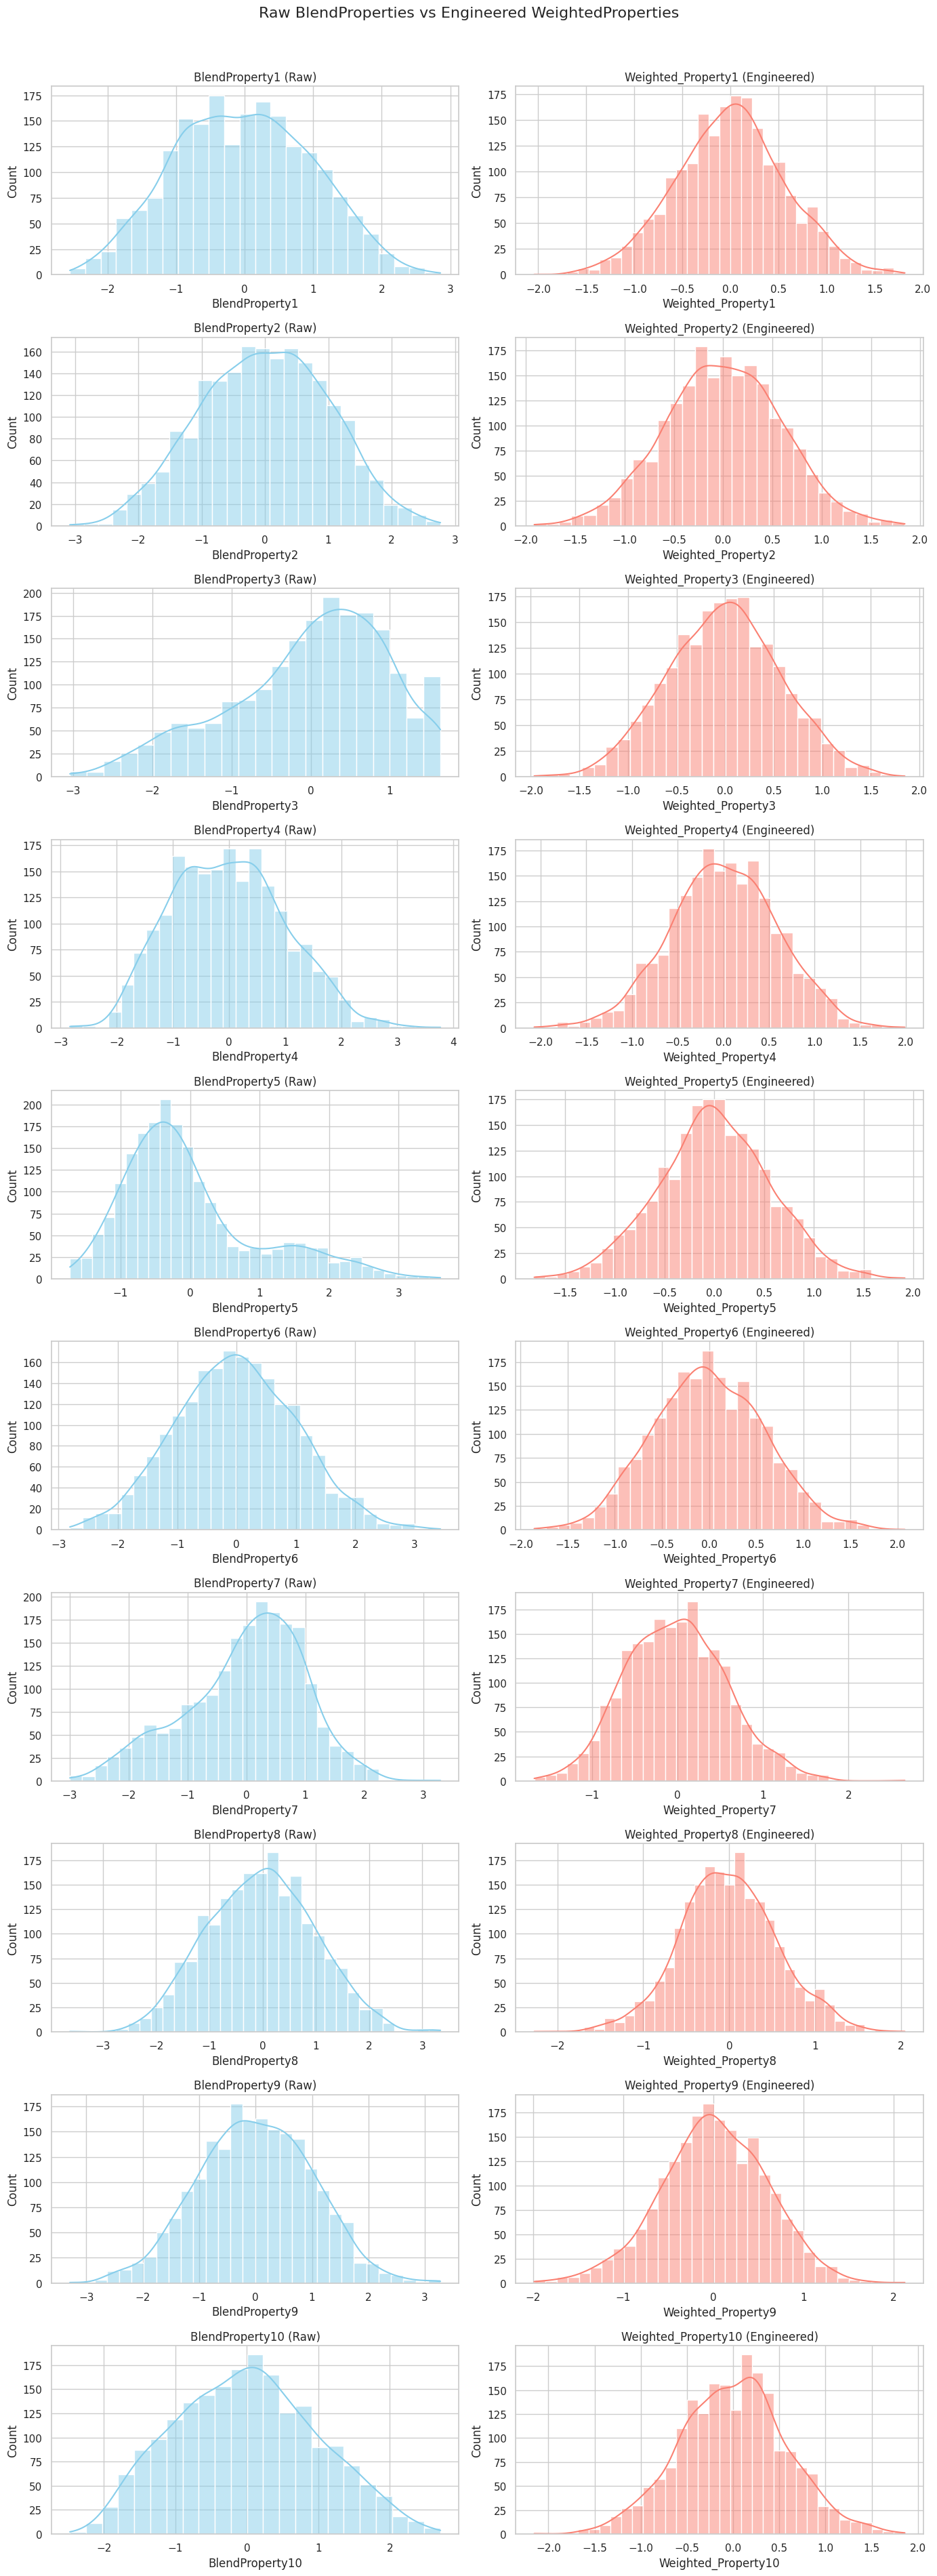

In [10]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------
# Load dataset from GitHub
# -----------------------------------
def load_data_from_github(url: str) -> pd.DataFrame:
    try:
        response = requests.get(url)
        response.raise_for_status()
        df = pd.read_csv(io.StringIO(response.text))
        print("✅ Successfully loaded data from GitHub")
        return df
    except Exception as e:
        raise RuntimeError(f"Error loading data from GitHub: {e}")

# -----------------------------------
# Feature Engineering
# -----------------------------------
def create_weighted_properties(df, num_components, num_properties):
    weighted_features = pd.DataFrame()
    for i in range(1, num_properties + 1):
        weighted_sum = np.zeros(len(df))
        for j in range(1, num_components + 1):
            weighted_sum += df[f'Component{j}_fraction'] * df[f'Component{j}_Property{i}']
        weighted_features[f'Weighted_Property{i}'] = weighted_sum
    return weighted_features

def create_statistical_features(df, num_components, num_properties):
    stats_features = pd.DataFrame()
    for i in range(1, num_properties + 1):
        values = np.stack([df[f'Component{j}_Property{i}'] for j in range(1, num_components + 1)], axis=1)
        stats_features[f'Property{i}_mean'] = values.mean(axis=1)
        stats_features[f'Property{i}_std'] = values.std(axis=1)
        stats_features[f'Property{i}_min'] = values.min(axis=1)
        stats_features[f'Property{i}_max'] = values.max(axis=1)
        stats_features[f'Property{i}_range'] = values.max(axis=1) - values.min(axis=1)
    return stats_features

def create_component_fraction_features(df, num_components):
    fraction_cols = [f'Component{j}_fraction' for j in range(1, num_components + 1)]
    fractions = df[fraction_cols].copy()
    fractions["Fraction_Entropy"] = -(fractions * np.log(fractions + 1e-10)).sum(axis=1)
    fractions["Dominant_Component"] = (
        fractions[fraction_cols].idxmax(axis=1)
        .str.extract('(\d+)')[0]
        .astype(float)
        .astype(pd.Int64Dtype())
    )
    return fractions

def engineer_features(df, num_components, num_properties):
    weighted = create_weighted_properties(df, num_components, num_properties)
    stats = create_statistical_features(df, num_components, num_properties)
    fractions = create_component_fraction_features(df, num_components)
    X = pd.concat([fractions, weighted, stats], axis=1)
    y = df[[f'BlendProperty{i}' for i in range(1, num_properties + 1)]]
    return X, y

# -----------------------------------
# Save and Plot
# -----------------------------------
def save_processed_data(X, y, path):
    df = pd.concat([X, y], axis=1)
    df.to_csv(path, index=False)
    print(f"✅ Feature-engineered dataset saved as: {path}")

def plot_comparison(raw_df, engineered_X, num_properties):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=num_properties, ncols=2, figsize=(14, 4 * num_properties))
    fig.suptitle("Raw BlendProperties vs Engineered WeightedProperties", fontsize=16)

    for i in range(1, num_properties + 1):
        sns.histplot(raw_df[f'BlendProperty{i}'], kde=True, ax=axes[i-1][0], color='skyblue')
        axes[i-1][0].set_title(f'BlendProperty{i} (Raw)')

        sns.histplot(engineered_X[f'Weighted_Property{i}'], kde=True, ax=axes[i-1][1], color='salmon')
        axes[i-1][1].set_title(f'Weighted_Property{i} (Engineered)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# -----------------------------------
# Main Execution
# -----------------------------------
if __name__ == "__main__":
    # Configuration
    GITHUB_RAW_URL = "https://raw.githubusercontent.com/Sinhavaishnavi/Fuel-Blend-Properties-Prediction/master/data/train.csv"
    OUTPUT_PATH = "cleaned_ml_ready_dataset.csv"
    NUM_COMPONENTS = 5
    NUM_PROPERTIES = 10

    # Run pipeline
    raw_df = load_data_from_github(GITHUB_RAW_URL)
    X_features, y_targets = engineer_features(raw_df, NUM_COMPONENTS, NUM_PROPERTIES)
    save_processed_data(X_features, y_targets, OUTPUT_PATH)
    plot_comparison(raw_df, X_features, NUM_PROPERTIES)
